# Model Building

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, auc, classification_report
from xgboost import XGBClassifier
from Codebase.models import TimeSeriesModelEvaluator
from Codebase.statistical_models import LinearRegressionPredictor

## Loading Data

In [2]:
df = pd.read_csv('./data/time-series1.csv')

## Preprocessing Data

In [3]:
# Convert the timestamp to a numerical value
df['timestamp_asint'] = pd.to_datetime(df['timestamp']).astype('int64')

df.head()

,rms,state,timestamp,timestamp_asint
0,0.236160,States.OFF,2021-01-01 00:00:00,1609459200000000000
1,1.485381,States.OFF,2021-01-01 00:00:10,1609459210000000000
2,1.128444,States.OFF,2021-01-01 00:00:20,1609459220000000000
3,1.190676,States.OFF,2021-01-01 00:00:30,1609459230000000000
4,1.441717,States.OFF,2021-01-01 00:00:40,1609459240000000000


In [4]:
# Encode the categorical state variable using one-hot encoding
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(df[['state']])
df[['States.ACTIVE', 'States.IDLE', 'States.OFF']] = y_encoded.toarray().astype(int)
df['state_encoded'] = np.argmax(y_encoded, axis=1)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[['timestamp_scaled', 'rms_scaled']] = scaler.fit_transform(df[['timestamp_asint', 'rms']])

In [6]:
df.columns = df.columns.map(str)
df.head(200)

,rms,state,timestamp,timestamp_asint,States.ACTIVE,States.IDLE,States.OFF,state_encoded,timestamp_scaled,rms_scaled
0,0.236160,States.OFF,2021-01-01 00:00:00,1609459200000000000,0,0,1,2,0.000000,0.000263
1,1.485381,States.OFF,2021-01-01 00:00:10,1609459210000000000,0,0,1,2,0.001346,0.001721
2,1.128444,States.OFF,2021-01-01 00:00:20,1609459220000000000,0,0,1,2,0.002692,0.001304
3,1.190676,States.OFF,2021-01-01 00:00:30,1609459230000000000,0,0,1,2,0.004038,0.001377
4,1.441717,States.OFF,2021-01-01 00:00:40,1609459240000000000,0,0,1,2,0.005384,0.001670
...,...,...,...,...,...,...,...,...,...,...
195,506.705862,States.ACTIVE,2021-01-01 00:32:30,1609461150000000000,1,0,0,0,0.262450,0.591398
196,466.630940,States.ACTIVE,2021-01-01 00:32:40,1609461160000000000,1,0,0,0,0.263795,0.544624
197,547.582753,States.ACTIVE,2021-01-01 00:32:50,1609461170000000000,1,0,0,0,0.265141,0.639108
198,587.969861,States.ACTIVE,2021-01-01 00:33:00,1609461180000000000,1,0,0,0,0.266487,0.686247


---
# Model Building

All models are subject to one shared limitation, in that they have only been trained on one dataset, meaning that if new data was given where the relationship between the features changed (e.g. a different vehicle with a different engine or drive cycle) the models may not perform well as they are likely overfit to this specific data example.

## Statistical Models

### Rolling Window Slope Estimation - `Linear Regression`

`Linear regression` models the relationship between two variables by fitting a linear equation to observed data. The values of 'a' and 'b' are estimated based on the input data. This is done by **minimizing the sum of the squared residuals**, also known as the **"least squares"** method. The residuals for an observation are the difference between the observation (the y-value) and the fitted line. For example, a simple linear regression model can be formulated as follows: `y = a + bx + e`

where:

- `y` is the dependent variable.
- `x` is the independent variable.
- `a` is the y-intercept.
- `b` is the slope.
- `e` is the error term.

This code calculates the slope of the 'rms' column of the dataframe using a rolling window of size 10. It then creates a new column 'engine_state' based on the slope value. If the slope is positive, the engine state is set to 0 (ACTIVE), otherwise it is set to 1 (IDLE). Additionally, if the 'rms' value is less than 2, the engine state is set to 2 (which represents 'OFF'). The function `calculate_slope` uses linear regression to calculate the slope of the window.

**Limitations**:

1. **Simplicity**: The model is quite simple and might not capture complex relationships between variables. For instance, it does not consider interactions between features or non-linear relationships.

2. **Linear Assumption**: The model assumes a linear relationship between time and feature values when calculating the slopes using linear regression, which may not always hold true.

3. **Arbitrary Thresholds**: Predictions are partially based on fixed thresholds (e.g., engine state changing when 'rms' is less than 2). These thresholds might not generalize well to different scenarios or datasets.

4. **Non-Adaptive**: The model doesn't learn or adapt over time as it receives more data. Unlike machine learning models, it cannot improve its predictions as more information becomes available.

5. **Lack of Robustness**: The model could be sensitive to outliers or noise in the data. A single outlier value can significantly affect the slope calculated for a rolling window.

6. **Assumes Stationarity**: The model implicitly assumes that the underlying data-generating process doesn't change over time. If there are trends, seasonality, or other non-stationary elements in the data, the model's performance might suffer.

7. **Class Imbalance**: If the target variable 'state_encoded' is imbalanced, some of the metrics may not provide a true picture of the model's performance. For example, accuracy can be misleadingly high when the model predominantly predicts the majority class.

Not considering sequence: The model fails to account for the sequence of the states. In many cases, including past states or a sequence of readings as part of the input data could improve prediction accuracy.

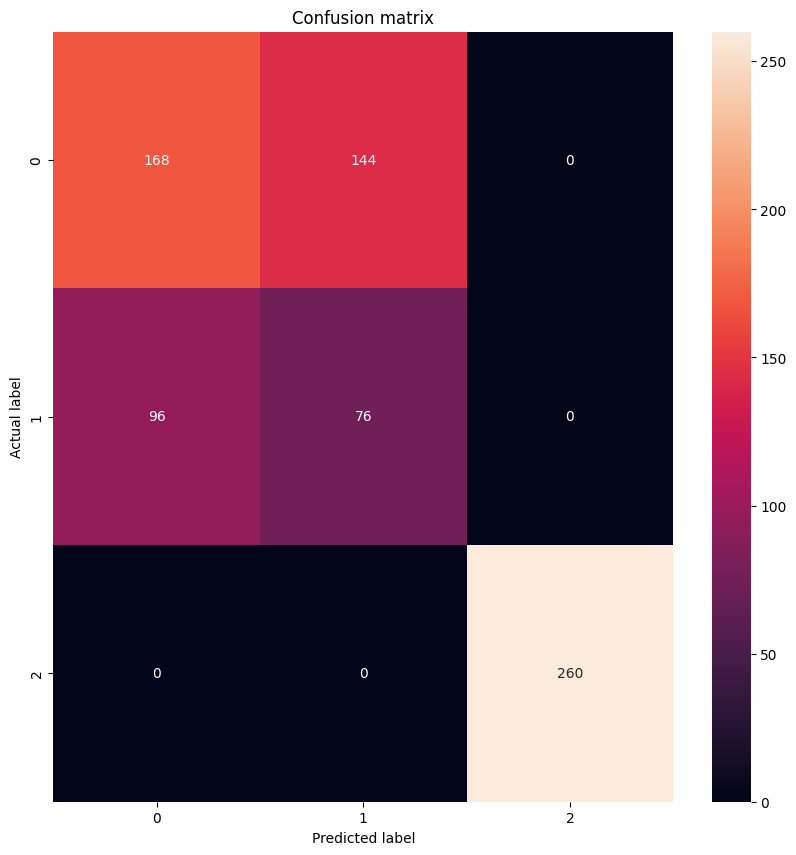

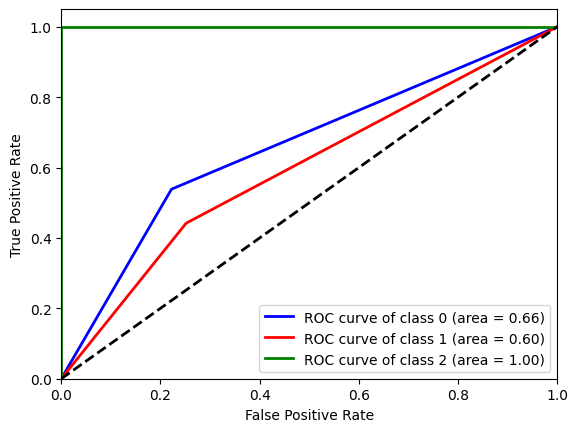

accuracy: 
0.6774193548387096
precision: 
0.6606060606060606
recall: 
0.6601073345259392
f1_score: 
0.6570294784580498
confusion_matrix: 
[[168 144   0]
 [ 96  76   0]
 [  0   0 260]]
classification_report: 
              precision    recall  f1-score   support

           0       0.64      0.54      0.58       312
           1       0.35      0.44      0.39       172
           2       1.00      1.00      1.00       260

    accuracy                           0.68       744
   macro avg       0.66      0.66      0.66       744
weighted avg       0.70      0.68      0.68       744

roc_auc: 
{0: 0.6581196581196581, 1: 0.5950561066840135, 2: 1.0}
average_roc_auc: 
0.7510585882678905


In [7]:
linear_regression = LinearRegression()
linear_regression_predictor = LinearRegressionPredictor(linear_regression)

df['engine_state'], metrics = linear_regression_predictor.predict(df)
for key, value in metrics.items():
    print(f'{key}: \n{value}')

## Model Evaluation Metrics

**`Precision`**:
Precision is the ratio of correctly predicted positive observations to the total predicted positives. It is a measure of a classifier's exactness. Low precision indicates a high number of false positives.

- **Class 0**: 64% of the instances predicted as class 0 were actually class 0.
- **Class 1**: 35% of the instances predicted as class 1 were actually class 1.
- **Class 2**: 100% of the instances predicted as class 2 were actually class 2. 

**`Recall`**:
Recall is the ratio of correctly predicted positive observations to the all observations in actual class. It is a measure of a classifier's completeness. Low recall indicates a high number of false negatives.

- **Class 0**: The model correctly identified 54% of the actual instances of class 0.
- **Class 1**: The model correctly identified 44% of the actual instances of class 1.
- **Class 2**: The model correctly identified 100% of the actual instances of class 2.

**`F1 Score`**:
The F1 Score is the weighted average of Precision and Recall. It tries to find the balance between precision and recall.

- **Class 0**: The F1 score is 0.58, indicating that the balance between precision and recall for class 0 predictions is fairly decent but there's room for improvement.
- **Class 1**: The F1 score is 0.39, indicating that the balance between precision and recall for class 1 predictions is lower than that of class 0 and 2. 
- **Class 2**: The F1 score is 1.00, indicating perfect balance between precision and recall for class 2 predictions.

**`Support`**:
Support is the number of actual occurrences of the class in the specified dataset. 

- **Class 0**: There are 312 instances of class 0 in the dataset.
- **Class 1**: There are 172 instances of class 1 in the dataset.
- **Class 2**: There are 260 instances of class 2 in the dataset.

**`Accuracy`**:
Accuracy is the most intuitive performance measure. It is simply a ratio of correctly predicted observation to the total observations. Here the accuracy is 0.68, meaning the model correctly predicted the class 68% of the time on the dataset.

**`Macro Average`**:
The macro average (macro avg) calculates the metric independently for each class and then takes the average, treating all classes equally. Here the average precision, recall, and F1 score are all 0.66.

**`Weighted Average`**:
The weighted average (weighted avg) calculates metrics for each label, and finds their average weighted by support (the number of true instances for each label). It can result in an F-score that is not between precision and recall. Here, the weighted average precision, recall, and F1 score are 0.70, 0.68, and 0.68, respectively.

**`ROC_AUC Score`**: The ROC AUC score tells us how efficient the model is. The higher the AUC, the better the model's performance at distinguishing between the positive and negative classes.

**`Confusion matrix`**: A table that summarizes the performance of a classification model by comparing predicted and actual values. It shows the number of true positives, false positives, true negatives, and false negatives.

From these metrics, we can see that the model has perfect precision and recall for class 2 but performs less well for classes 0 and 1, especially for class 1 which has the lowest precision, recall and F1 score. This could be due to various reasons, such as class imbalance or the model's inability to capture the characteristics of class 1.


**Improvements**:

1. **Augmented Dicky Fuller**: An `Augmented Dicky Fuller` test is a statistical procedure used to determine if a time series is stationary or non-stationary. A stationary time series is one where statistical properties — like the mean and variance — are constant over time. The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

In general, the steps to interpret the results of this test are:

- If the test statistic is less than the critical value, we can reject the null hypothesis (aka, we can reject the hypothesis that the time series is non-stationary).
- If the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the time series is non-stationary).

This could be incorporated into the model, to ensure that the data is non-stationary before applying the engine_state logic. This ensures that small values for the slope (which could be accounted for by noise) are not taken as a state change.

2. **Alternative Function Estimation**: You could use a non-linear function estimator instead of Linear Regression to get a more accurate representation of the relationship between features. `Polynomial regression` or `decision tree regression` is likely more suitable for this problem as they can capture more complex relationships between features.

In [8]:
from statsmodels.tsa.stattools import adfuller
# Perform Augmented Dickey-Fuller test:
print('Results of Augmented Dickey-Fuller Test:')
dftest = adfuller(df['rms'], autolag='AIC')  # change 'vibration' to your column name

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -1.959854
p-value                          0.304448
#Lags Used                       6.000000
Number of Observations Used    737.000000
Critical Value (1%)             -3.439254
Critical Value (5%)             -2.865470
Critical Value (10%)            -2.568863
dtype: float64


---
## Machine-Learning Models
Data will be split using train_test_split (taking the last 25% as the test data). Ideally, TimeSeriesSplit would have been used, however due to the structure of the dataset it cannot be guaranteed that there is an example for each class within the validation set/test set/train set which results in errors. It would be recommended to use TimeSeriesSplit if the dataset allows.

### Logistic Regression

Instead of fitting a line to the data as in linear regression, logistic regression fits an S-shaped logistic function. The output of logistic regression is a probability that the given input point belongs to a certain class. The central premise of Logistic Regression is the assumption that your input space can be separated into two or more 'regions', one for each class, by a linear boundary.

**Limitations**:

1. **Linearity Assumption**: Logistic regression assumes a linear relationship between the log-odds of the response and predictors, hence, the decision boundary must be linear.

2. **Sensitive to Outliers**: Outliers can significantly influence the estimation of the regression coefficients, hence the prediction.

3. **Multicollinearity**: Logistic Regression does not handle highly correlated inputs very well. High correlation among features can lead to unstable coefficient estimates. 

4. **Large Sample Size Requirement**: To achieve stable and meaningful results, Logistic Regression requires a large sample size.

5. **No Temporal Element**: Logistic Regression does not contain any method to use previous observations as features for new predictions, thus it does not take into account the temporal element of the data.

**Parameters**:

- **`Penalty`**: The penalty parameter specifies the type of regularization applied to the coefficients to prevent overfitting
    1. `'l1' penalty`: This stands for `L1` regularization. `L1` regularization adds a penalty equal to the absolute value of the magnitude of coefficients. Some coefficients can become zero, which is equivalent to the particular feature being excluded from the model.

    2. `'l2' penalty`: This stands for `L2` regularization. `L2` regularization adds a penalty equal to the square of the magnitude of coefficients. All coefficients are shrunk by the same factor (none are eliminated). Results in a more complex and less interpretable model.

    3. `'Elastic Net' penalty`: Elastic Net is a regularization technique that linearly combines the `L1` and `L2` penalties of the Lasso and Ridge methods.

- **`C`**: The '`C`' parameter in Logistic Regression determines the inverse of the regularization strength. In other words, it is the inverse of the lambda (`λ`) parameter in the regularization term. Smaller values of '`C`' specify stronger regularization.
    - A smaller value of `C` creates a wider margin of the hyperplane, but more classification errors (underfitting issues).
    - A larger value of `C` creates a smaller margin of the hyperplane, but fewer classification errors (overfitting issues).

c:\Users\Danie\miniconda3\envs\MachineMax\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Danie\miniconda3\envs\MachineMax\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Danie\miniconda3\envs\MachineMax\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\Danie\miniconda3\envs\MachineMax\lib\site-packages\sklearn\linear_model\

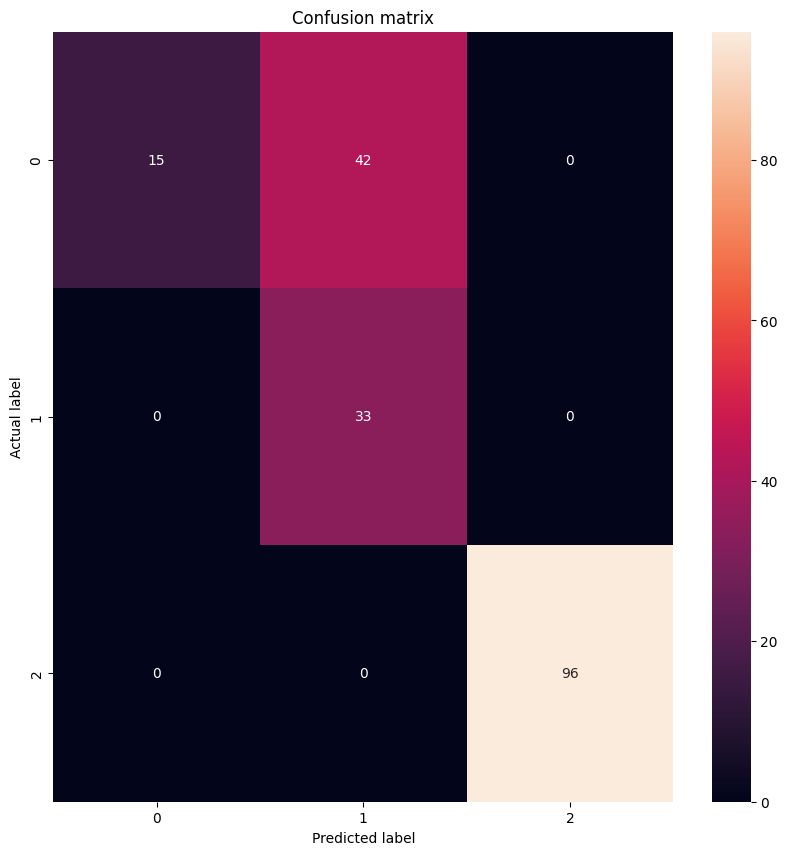

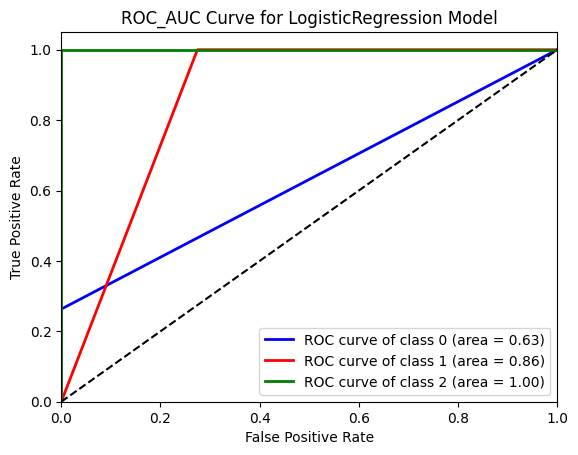

Best hyperparameters: {'penalty': 'l2', 'C': 5.0}


In [31]:
# Train a logistic regression model
model = LogisticRegression()

hyperparams = {
    'penalty': ['l1', 'l2', 'elasticnet', 'None'],
    'C': [1.0, 2.0, 5.0],
}

evaluator = TimeSeriesModelEvaluator(model, hyperparams)

LR_metrics = evaluator.evaluate(
    X=df[['timestamp_scaled', 'rms_scaled']].values,
    y=df['state_encoded'].values
)

In [32]:
# print the metrics
for key, value in LR_metrics.items():
    print(f"{key}: \n{value}")

accuracy: 
0.7741935483870968
precision: 
0.8133333333333334
recall: 
0.7543859649122807
f1_score: 
0.6759259259259259
confusion_matrix: 
[[15 42  0]
 [ 0 33  0]
 [ 0  0 96]]
classification_report: 
              precision    recall  f1-score   support

           0       1.00      0.26      0.42        57
           1       0.44      1.00      0.61        33
           2       1.00      1.00      1.00        96

    accuracy                           0.77       186
   macro avg       0.81      0.75      0.68       186
weighted avg       0.90      0.77      0.75       186

roc_auc: 
{0: 0.631578947368421, 1: 0.8627450980392157, 2: 1.0}
average_roc_auc: 
0.8314413484692121


## Model Evaluation Metrics

**`Precision`**:
- **Class 0**: 100% of the instances predicted as class 0 were actually class 0.
- **Class 1**: 44% of the instances predicted as class 1 were actually class 1.
- **Class 2**: 100% of the instances predicted as class 2 were actually class 2.

**`Recall`**:
- **Class 0**: The model correctly identified 26% of the actual instances of class 0.
- **Class 1**: The model correctly identified 100% of the actual instances of class 1.
- **Class 2**: The model correctly identified 100% of the actual instances of class 2.

**`F1 Score`**:
- **Class 0**: The F1 score is 0.42, indicating that there is a trade-off between precision and recall for class 0 predictions; while precision is high, recall is relatively low.
- **Class 1**: The F1 score is 0.61, indicating a better balance between precision and recall for class 1 predictions compared to class 0, though still room for improvement.
- **Class 2**: The F1 score is 1.00, indicating perfect balance between precision and recall for class 2 predictions.

### **Improvements**:
1. **Address Linearity Assumption**: Since the relationship between the features may not be linear, the most significant improvement would be to use an alternative model that can estimate non-linear relationships.

2. **Address Misclassification of ACTIVE**: As can be seen from the confusion matrix, most of the models error is coming from misclassification of state 0 (ACTIVE) as state 1 (IDLE). As such, it would be recommended to gather some additional data with  more instances of state 0 to train the model on.

3. **Gather more diverse data**: The model has only been trained on data from one sensor attached to one vehicle. The data coming into the model is likely to look slightly different for each vehicle/sensor, therfore the model may not perform well when exposed to new data.

---
### Random Forest

**Limitations**:

1. **Model Interpretability**: Random forests are generally considered pseudo black-box models, making them less intuitive than models like linear regression or base decision trees. Understanding why a Random Forest model made a certain prediction can be more challenging than with other models.

3. **Prediction & Training Speed**: Random forests require more time to train than some other models because they generate many decision trees (often hundreds or thousands) and make predictions by averaging the results of those trees. This can be computationally intensive for large datasets or for datasets with a large number of features. Although prediction time is usually faster than training time, it can still be slow if the number of trees is large which may not be applicable for a real-time use-case. 

4. **Memory Consumption**: Random forests can consume a lot of memory if the number of trees is large or the depth of trees is high.

4. **Cannot Extrapolate**: Like decision trees, random forests cannot extrapolate patterns in data. They are not effective at predicting outside the range of the training data.

5. **High Cardinality Features**: Random Forests do not work well with high cardinality categorical variables (variables with a large number of unique categories).


**Parameters**:

- **`n_estimators`**: Defines the number of trees in the forest. More trees can improve performance but increases computational cost.

- **`max_features`**: Determines the number of features to consider for the best split. Smaller values increase randomness and can reduce overfitting.

- **`max_depth`**: Controls maximum tree depth. Deeper trees can model complex relationships but risk overfitting.

- **`min_samples_split`**: Sets the minimum number of samples needed to split a node. Higher values can prevent overfitting but risk underfitting.

- **`min_samples_leaf`**: Sets the minimum number of samples required at a leaf node. Smaller leaves can capture noise in training data.

- **`bootstrap`**: If False, the whole dataset is used to build each tree.

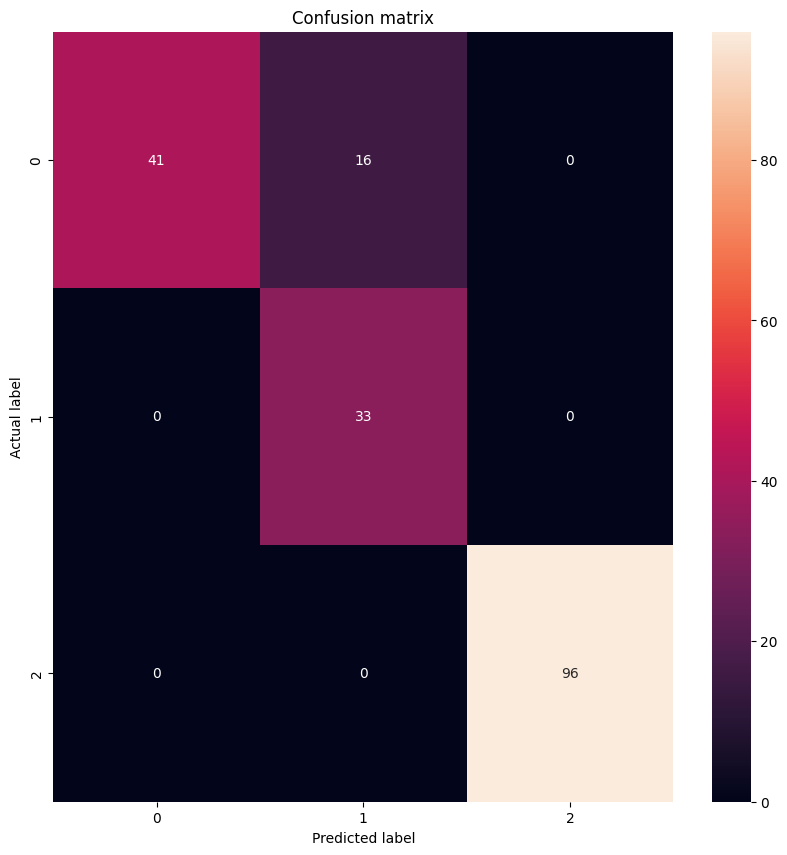

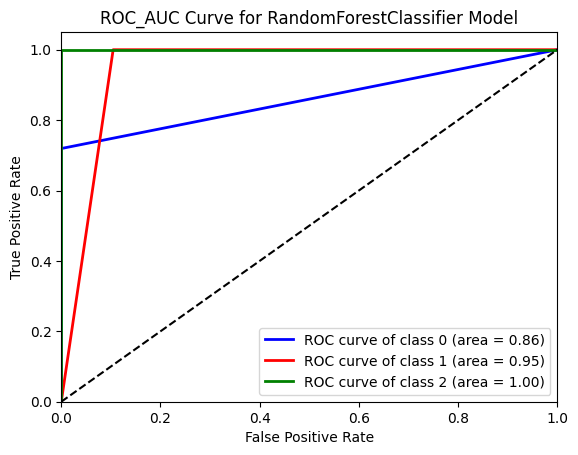

Best hyperparameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': False}


In [11]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': [False] # This is set to false because we are using time series data
}

evaluator = TimeSeriesModelEvaluator(rf, random_grid)

RF_metrics = evaluator.evaluate(
    X=df[['timestamp_scaled', 'rms_scaled']].values,
    y=df['state_encoded'].values
)

In [12]:
# print the metrics
for key, value in RF_metrics.items():
    print(f"{key}: \n{value}\n")

accuracy: 
0.9139784946236559

precision: 
0.891156462585034

recall: 
0.9064327485380117

f1_score: 
0.880537580886013

confusion_matrix: 
[[41 16  0]
 [ 0 33  0]
 [ 0  0 96]]

classification_report: 
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        57
           1       0.67      1.00      0.80        33
           2       1.00      1.00      1.00        96

    accuracy                           0.91       186
   macro avg       0.89      0.91      0.88       186
weighted avg       0.94      0.91      0.92       186


roc_auc: 
{0: 0.8596491228070176, 1: 0.9477124183006537, 2: 1.0}

average_roc_auc: 
0.9357871803692238



### Model Evaluation Metrics

**`Precision`**:
- **Class 0**: 100% of the instances predicted as class 0 were actually class 0.
- **Class 1**: 67% of the instances predicted as class 1 were actually class 1.
- **Class 2**: 100% of the instances predicted as class 2 were actually class 2.

**`Recall`**:
- **Class 0**: The model correctly identified 72% of the actual instances of class 0.
- **Class 1**: The model correctly identified 100% of the actual instances of class 1.
- **Class 2**: The model correctly identified 100% of the actual instances of class 2.

**`F1 Score`**:
- **Class 0**: The F1 score is 0.84, indicating a very good balance between precision and recall for class 0 predictions.
- **Class 1**: The F1 score is 0.80, indicating a good balance between precision and recall for class 1 predictions, though there's a slight trade-off in favour of recall.
- **Class 2**: The F1 score is 1.00, indicating perfect balance between precision and recall for class 2 predictions.

### **Improvements**:
1. **Gather more diverse data**: Similar to the previous model, it's advisable to train on more diverse data, especially since RandomForest models don't generalise well to data outside the training set.

2. **Further Parameter Tuning**: Do a more exhaustive search when tuning hyperparameters to ensure the model has fully converged. Although beware that this can lead to overfitting.

---
### XGBoost

XGBoost stands for eXtreme Gradient Boosting, a powerful ensemble learning method:

1. **Ensemble Learning**: Combines predictions from multiple simpler models (base learners).

2. **Gradient Boosting**: Builds the model in a stage-wise fashion, with each subsequent model attempting to correct the errors of the previous one.

3. **Regularization**: Includes a regularization term in its cost function to control the model's complexity and prevent overfitting.

4. **Handling Missing Values and Outliers**: Has an in-built routine to handle missing values and is robust to outliers.

5. **Parallel and Distributed Computing**: Uses multiple CPU cores and can be distributed across a cluster to handle large datasets.

6. **Tree Pruning**: Uses "max_depth" as a stopping criterion and prunes trees backward to prevent overfitting.

7. **Handling Sparse Data**: Can handle sparse data and assigns a direction to missing values during split decisions.

**Limitations**:

1. **Parameter Tuning**: XGBoost has many hyperparameters that can be challenging and time-consuming to optimize.

2. **Computational Intensity**: Despite its speed compared to other ensemble classifiers, XGBoost can still be slow with large datasets or during cross-validation.

3. **Risk of Overfitting**: Without proper regularization or if overly complex, XGBoost can overfit the training data.

4. **Interpretability**: While XGBoost can calculate feature importance, it lacks specific coefficient values for interpretability, unlike linear models.

5. **Sensitivity to Noise**: XGBoost can potentially overfit to noise in the data, hence preprocessing and proper feature selection are crucial.

6. **Linear Relationships**: For relationships between features and target that are essentially linear, linear models might outperform XGBoost.

**Parameters**:

**XGBoost Parameters**

1. **`learning_rate`** (`eta`): Scales the contribution of each tree. Lower values require more trees but can lead to better performance.

2. **`n_estimators`**: The number of boosting rounds or trees. Dictates the training length.

3. **`max_depth`**: Controls the depth of each tree. Deeper trees can model complex interactions but may overfit.

4. **`min_child_weight`**: The parameter is used to control the complexity of the trees. A smaller min_child_weight allows the algorithm to create children that correspond to fewer samples, thus allowing for more complex trees, but also potentially overfitting.

4. **`gamma`**: Minimum loss reduction required for further partition on a leaf node. Larger values make the model more conservative.

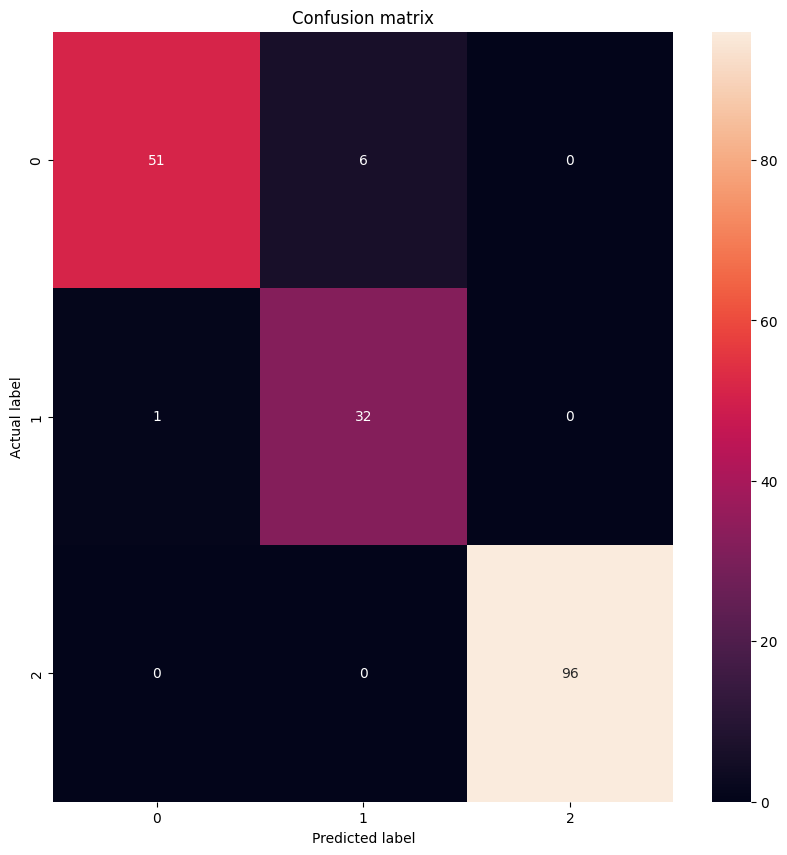

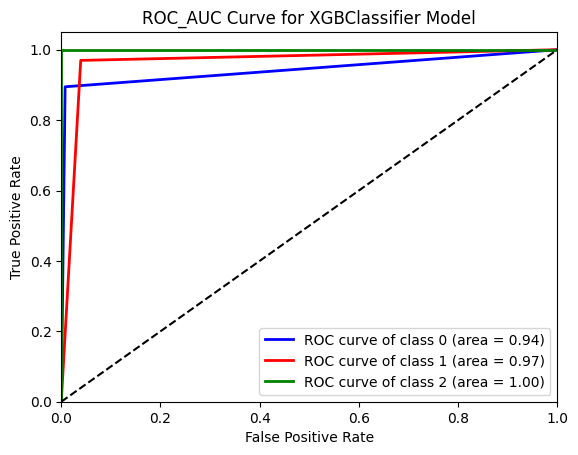

Best hyperparameters: {'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.15, 'gamma': 0.1}


In [30]:
# Instantiate XGBoost classifier
xgb_model = XGBClassifier()

# Hyperparameters for XGBoost
hyperparams = {
    'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
    'n_estimators' : [100, 250, 500, 750, 1000],
    'max_depth' : [3, 4, 5, 6, 8, 10, 12, 15],
    'min_child_weight' : [ 1, 3, 5, 7 ],
    'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]
}

# Instantiate the evaluator with the XGBoost classifier
evaluator = TimeSeriesModelEvaluator(xgb_model, hyperparams)

# Use your dataframe's feature and target columns as X and y
X = df[['timestamp_scaled', 'rms_scaled']].values
y = df['state_encoded'].values

# Evaluate the model
xg_metrics = evaluator.evaluate(X, y)

In [14]:
# print the metrics
for key, value in xg_metrics.items():
    print(f"{key}: \n{value}\n")

accuracy: 
0.9623655913978495

precision: 
0.9409581646423751

recall: 
0.9548112706007443

f1_score: 
0.9457294224059956

confusion_matrix: 
[[51  6  0]
 [ 1 32  0]
 [ 0  0 96]]

classification_report: 
              precision    recall  f1-score   support

           0       0.98      0.89      0.94        57
           1       0.84      0.97      0.90        33
           2       1.00      1.00      1.00        96

    accuracy                           0.96       186
   macro avg       0.94      0.95      0.95       186
weighted avg       0.97      0.96      0.96       186


roc_auc: 
{0: 0.9434924520603836, 1: 0.9652406417112299, 2: 1.0}

average_roc_auc: 
0.9695776979238712



### Model Evaluation Metrics

**`Precision`**:
- **Class 0**: 98% of the instances predicted as class 0 were actually class 0.
- **Class 1**: 84% of the instances predicted as class 1 were actually class 1.
- **Class 2**: 100% of the instances predicted as class 2 were actually class 2.

**`Recall`**:
- **Class 0**: The model correctly identified 89% of the actual instances of class 0.
- **Class 1**: The model correctly identified 97% of the actual instances of class 1.
- **Class 2**: The model correctly identified 100% of the actual instances of class 2.

**`F1 Score`**:
- **Class 0**: The F1 score is 0.94, indicating an excellent balance between precision and recall for class 0 predictions.
- **Class 1**: The F1 score is 0.90, indicating a strong balance between precision and recall for class 1 predictions, but with a slight trade-off in favor of recall.
- **Class 2**: The F1 score is 1.00, indicating perfect balance between precision and recall for class 2 predictions.

**Improvements**:
- **Feature Engineering**: Incorporating lagged variables, moving averages, or other time-dependent variables could help improve model performance and adds a temporal element to the feature vector.

- **Explainability**: Techniques like SHAP could be used on the model to gain better insight into how it determines which state for a given feature vector. However, as XGBoost models are ensemble methods, this is more difficult to get meaningful information from.

---
## Next Steps to improve models

1. **Produce several datasets using the data generator**:
- You should vary the rms_value ranges for each dataset to simulate sensors being placed on different vehicle types.
- This more varied set of data could be used to iteratively train the models, ensuring they have a better representation of real-world data.

2. **Incorporate Interpretability metrics**:
- By incorporating interpratibility metrics, such as SHAP, we can gain a better insight into the decision making process of our models.

3. **Investigate additional models**:
- Additional models, such as LSTM, should be investigated to assess their performance on the dataset. It is expected that for a problem such as this, LSTMs or deep-learning in general is overkill, however it should still be verified.

4. **Investigate Feature Engineering**:
- Assess the effect on model performance of adding additional features to the model inputs (such as using a rolling window to calculate the mean, variance, std, etc. for a period of time). Doing this could incorporate a temporal element into the models, potentially allowing them to learn more complex temporal relationships between data points.
